In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.datasets import mnist # for CNN we want the non-flatten mnist dataset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

## Utility functions

In [29]:
# plot performances
def model_performance(histories):
    fig = plt.figure(figsize=(15, 5))
    for i in range(len(histories)):
        # plot loss
        plt.subplot(1, 2, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.xticks([0, 1, 2, 3, 4])
        plt.legend(['train', 'test'], loc='upper right')
        # plot accuracy
        plt.subplot(1, 2, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.xticks([0, 1, 2, 3, 4])
        plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [67]:
# score
def score(model, testX, testY):
    sco = model.evaluate(
        testX,
        to_categorical(testY)
    )
    result = "This model achieved {:.3f} test loss and {:.2f} % test accuracy".format(sco[0], sco[1]*100)
    return result

## Dataset loading and pre-treatment

In [2]:
(trainX, trainY), (testX, testY) = mnist.load_data()

In [3]:
print(trainX.shape) # (60000, 28, 28)
print(trainY.shape) # (60000,)

(60000, 28, 28)
(60000,)


In [4]:
# Normalizing in the interval [-0.5, 0.5]
trainX = (trainX / 255) - 0.5
testX = (testX / 255) - 0.5

In [5]:
# Reshaping the images (keras expects a 3D array)
trainX = np.expand_dims(trainX, axis=3)
testX = np.expand_dims(testX, axis=3)

print(trainX.shape) # (60000, 28, 28, 1)
print(testX.shape)  # (10000, 28, 28, 1)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Models

In [34]:
def define_model_1():
    num_filters = 8
    kernel_size = 3
    pool_size = 2
    model = Sequential([
        Conv2D(num_filters, kernel_size, activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=pool_size),
        Dropout(0.5),
        Flatten(),
        Dense(10, activation='softmax'),
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

In [36]:
print(define_model_1().summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 8)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 13, 13, 8)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 1352)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
# reasonable "best" model ?? https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist
def define_best_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=5, padding='same', activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))
    model.add(Conv2D(64, kernel_size=5, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))


    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

In [52]:
print(define_best_model().summary())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 3136)            

## Model evaluation

In [42]:
def evaluate_model(model, dataX, dataY, n_folds=5, epochs=8, verbose=0, batch_size=32):
    histories = list()
    kfold = KFold(n_folds, shuffle=True, random_state=42)
    for train_index, test_index in kfold.split(dataX):
        trainX, testX = dataX[train_index], dataX[test_index]
        trainY, testY = dataY[train_index], dataY[test_index]
        # fit model
        history = model.fit(
            trainX,
            to_categorical(trainY),
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(testX, to_categorical(testY)),
            verbose=verbose
        )
        histories.append(history)
    return histories

In [43]:
histories_model_1 = evaluate_model(define_model_1(), trainX, trainY, verbose=2)

Epoch 1/8
1500/1500 - 13s - loss: 0.4464 - accuracy: 0.8740 - val_loss: 0.2000 - val_accuracy: 0.9441
Epoch 2/8
1500/1500 - 13s - loss: 0.2322 - accuracy: 0.9301 - val_loss: 0.1423 - val_accuracy: 0.9612
Epoch 3/8
1500/1500 - 13s - loss: 0.1915 - accuracy: 0.9424 - val_loss: 0.1179 - val_accuracy: 0.9668
Epoch 4/8
1500/1500 - 12s - loss: 0.1697 - accuracy: 0.9474 - val_loss: 0.1040 - val_accuracy: 0.9712
Epoch 5/8
1500/1500 - 13s - loss: 0.1584 - accuracy: 0.9523 - val_loss: 0.0966 - val_accuracy: 0.9731
Epoch 6/8
1500/1500 - 11s - loss: 0.1461 - accuracy: 0.9558 - val_loss: 0.0917 - val_accuracy: 0.9744
Epoch 7/8
1500/1500 - 11s - loss: 0.1373 - accuracy: 0.9583 - val_loss: 0.0892 - val_accuracy: 0.9751
Epoch 8/8
1500/1500 - 11s - loss: 0.1326 - accuracy: 0.9599 - val_loss: 0.0832 - val_accuracy: 0.9772
Epoch 1/8
1500/1500 - 13s - loss: 0.1306 - accuracy: 0.9598 - val_loss: 0.0706 - val_accuracy: 0.9804
Epoch 2/8
1500/1500 - 12s - loss: 0.1223 - accuracy: 0.9621 - val_loss: 0.0673 - v

<ipython-input-29-19831fb7382a>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1)
<ipython-input-29-19831fb7382a>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 2)


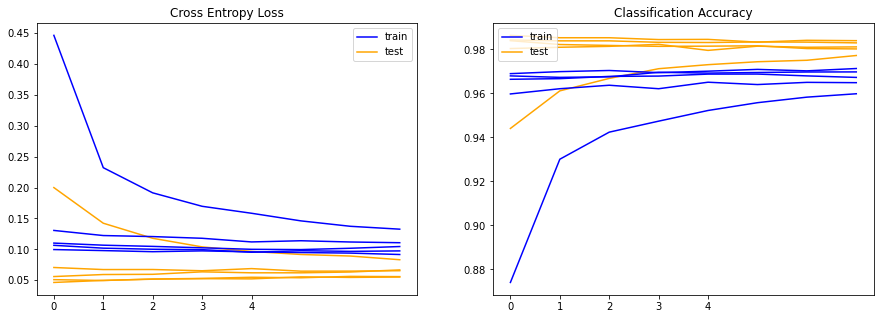

In [46]:
model_performance(histories_model_1)

In [53]:
histories_best_model = evaluate_model(define_best_model(), trainX, trainY, verbose=1, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 117s 77ms/step - loss: 0.5177 - accuracy: 0.8297 - val_loss: 0.0561 - val_accuracy: 0.9837
Epoch 2/5
1500/1500 [==============================] - 115s 77ms/step - loss: 0.1014 - accuracy: 0.9684 - val_loss: 0.0434 - val_accuracy: 0.9877
Epoch 3/5
1500/1500 [==============================] - 98s 66ms/step - loss: 0.0732 - accuracy: 0.9787 - val_loss: 0.0420 - val_accuracy: 0.9869
Epoch 4/5
1500/1500 [==============================] - 104s 69ms/step - loss: 0.0660 - accuracy: 0.9792 - val_loss: 0.0367 - val_accuracy: 0.9890
Epoch 5/5
1500/1500 [==============================] - 122s 81ms/step - loss: 0.0603 - accuracy: 0.9829 - val_loss: 0.0366 - val_accuracy: 0.9903
Epoch 1/5
1500/1500 [==============================] - 152s 101ms/step - loss: 0.0557 - accuracy: 0.9839 - val_loss: 0.0182 - val_accuracy: 0.9947
Epoch 2/5
1500/1500 [==============================] - 133s 88ms/step - loss: 0.0492 - accuracy: 0.9851 - val_loss: 0.0219 -

<ipython-input-29-19831fb7382a>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1)
<ipython-input-29-19831fb7382a>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 2)


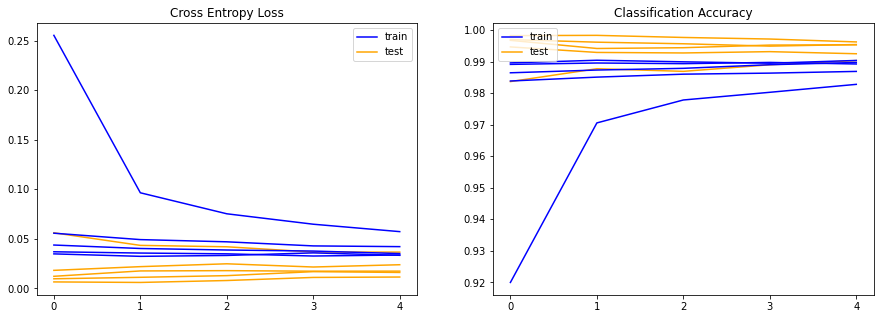

In [54]:
model_performance(histories_best_model)

In [55]:
final_model = define_best_model()

In [56]:
final_model.fit(
    trainX,
    to_categorical(trainY),
    epochs=10,
    batch_size=32
)

Epoch 1/10
1875/1875 [==============================] - 152s 80ms/step - loss: 0.4583 - accuracy: 0.8501
Epoch 2/10
1875/1875 [==============================] - 149s 79ms/step - loss: 0.0890 - accuracy: 0.9725
Epoch 3/10
1875/1875 [==============================] - 142s 76ms/step - loss: 0.0684 - accuracy: 0.9796
Epoch 4/10
1875/1875 [==============================] - 140s 75ms/step - loss: 0.0569 - accuracy: 0.9825
Epoch 5/10
1875/1875 [==============================] - 136s 72ms/step - loss: 0.0474 - accuracy: 0.9860
Epoch 6/10
1875/1875 [==============================] - 146s 78ms/step - loss: 0.0438 - accuracy: 0.9868
Epoch 7/10
1875/1875 [==============================] - 155s 83ms/step - loss: 0.0413 - accuracy: 0.9877
Epoch 8/10
1875/1875 [==============================] - 149s 79ms/step - loss: 0.0417 - accuracy: 0.9873
Epoch 9/10
1875/1875 [==============================] - 139s 74ms/step - loss: 0.0373 - accuracy: 0.9884
Epoch 10/10
1875/1875 [==============================] 

In [68]:
score(final_model, testX, testY)

313/313 [==============================] - 5s 16ms/step - loss: 0.0221 - accuracy: 0.9930


'This model achieved 0.022 test loss and 99.30 % test accuracy'

In [73]:
# Store the predictions
predictions = final_model.predict(testX)
predicted = np.argmax(predictions, axis=1)

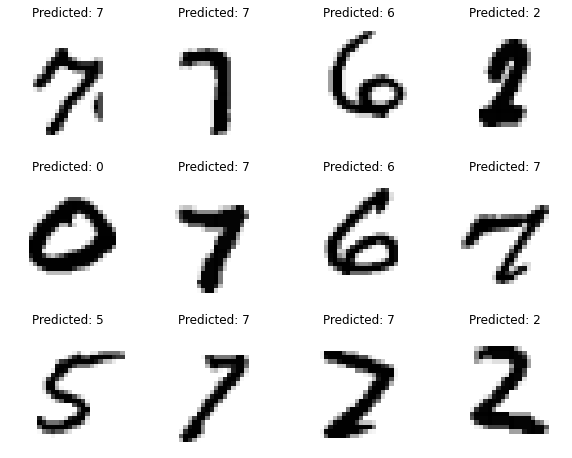

In [74]:
# We randomly pick 12 images
images = testX.reshape((-1, 28, 28))

select = np.random.randint(testX.shape[0], size=12)

fig = plt.figure(figsize=(10,8))
for index, value in enumerate(select):
    fig.add_subplot(3,4,index+1)
    plt.axis('off')
    plt.imshow((images[value]+0.5)*255,cmap=plt.cm.gray_r,interpolation="nearest")
    plt.title('Predicted: {}'.format(predicted[value]))


<AxesSubplot:>

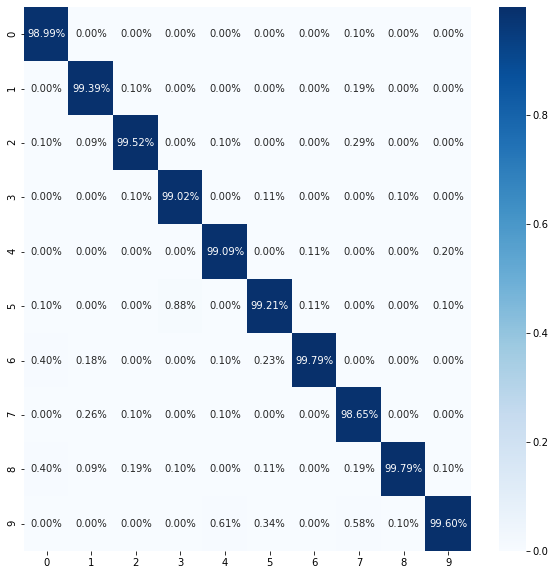

In [75]:
cf_matrix = confusion_matrix(testY, predicted)
plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix / sum(cf_matrix), fmt = '.2%', annot=True, cmap='Blues')